In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential

import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import AUC, BinaryAccuracy

import seaborn as sns

print(tf.test.is_built_with_cuda())
gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

from config import img_size, batch_size, model_path


from ipywidgets import interact
import ipywidgets as widgets

import IPython.display

False
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the data

In [2]:
def load_data():
    df = pd.read_csv("data/HAM10000_metadata.csv")
    df["label"] = df["dx"].apply(lambda dx: "malignant" if dx in ["akiec", "bcc", "mel"] else "benign") 
    df["image_id"] = df["image_id"].apply(lambda id: f"{id}.jpg")

    df_benign = df[df["label"] == "benign"]
    df_malignant = df[df["label"] == "malignant"]
    df = pd.concat([df_benign.sample(frac=0.25, random_state=0), df_malignant])
    
    df = df.sample(frac=1, random_state=0)

    # print(len(df))
    # print(len(df[df["label"] == "benign"]))
    # print(len(df[df["label"] == "malignant"]))

    # print(df.head())

    # 3969
    
    training_df = df[:3000]
    validation_df = df[3000:3500]
    testing_df = df[3500:]

    print(f"Malignant proportion in training set: {len(training_df[training_df['label'] == 'malignant']) / float(len(training_df))}")
    print(f"Malignant proportion in validation set: {len(validation_df[validation_df['label'] == 'malignant']) / float(len(validation_df))}")
    print(f"Malignant proportion in test set: {len(testing_df[testing_df['label'] == 'malignant']) / float(len(testing_df))}")
    
    
    training_data_generator = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.85, 1.15],
        zoom_range=[0.85, 1.15]
    )

    validation_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    testing_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    training_data = training_data_generator.flow_from_dataframe(
        dataframe= training_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=["benign", "malignant"],
        shuffle=False
    )

    validation_data = validation_data_generator.flow_from_dataframe(
        dataframe=validation_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=["benign", "malignant"],
        shuffle=False
    )

    test_data = testing_data_generator.flow_from_dataframe(
        dataframe=testing_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        class_mode="binary",
        classes=["benign", "malignant"],
        batch_size=1015,
        shuffle=False
    )

    return training_data, validation_data, test_data


### Creating the model
Explanation of why the model looks like it does

In [3]:
def create_model():
    _metrics = [BinaryAccuracy(name="accuracy"), AUC(name="auc")]

    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=_metrics)

    # model =  Sequential()
    # model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(img_size, img_size, 3)))
    # model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='valid'))
    # model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    # model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))
    # model.compile(optimizer='adam', loss="binary_crossentropy", metrics=_metrics)

    return model

### Training the model

In [4]:
def train_model(model, training_data, validation_data, epochs=2):
    history = model.fit(training_data, epochs=epochs, validation_data=validation_data, verbose=1)
    return history

### Evaluate the model

In [5]:
def evaluate_model(model, test_data):
    data_tuple = test_data[0]
    inputs = data_tuple[0]
    predicted = model.predict(inputs)
    ground_truth = [x[1] for x in data_tuple[1]]
    predictions = [x[1] for x in predicted]
    rounded_ground_truth = [round(x) for x in ground_truth]
    rounded_predictions = [round(x) for x in predictions]
    print("---- Ground truth ----")
    print(f"Min: {np.min(ground_truth)}")
    print(f"Max: {np.max(ground_truth)}")
    print(f"Mean: {np.mean(ground_truth)}")
    print(f"Mean rounded: {np.mean(rounded_ground_truth)}")
    print("---- Predictions ----")
    print(f"Min: {np.min(predictions)}")
    print(f"Max: {np.max(predictions)}")
    print(f"Mean: {np.mean(predictions)}")
    print(f"Mean rounded: {np.mean(rounded_predictions)}")
    return accuracy_score(rounded_ground_truth, rounded_predictions), f1_score(rounded_ground_truth, rounded_predictions)

Comments on the results

In [6]:
def save_model(model, path):
    #model.save_weights(path + '/tf')
    model.save(path)

### Putting it all together

In [7]:
model = create_model()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 64)                15241280  
                                                                 
 dense_1 (Dense)             (None, 1)   

2022-03-09 20:58:44.898664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 20:58:44.898777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model = create_model()
training_data, validation_data, test_data = load_data()
training_result = train_model(model, training_data, validation_data, epochs=200)

Malignant proportion in training set: 0.49633333333333335
Malignant proportion in validation set: 0.468
Malignant proportion in test set: 0.4925373134328358
Found 3000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.
Epoch 1/200


2022-03-09 20:58:56.740202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 0.9576 - accuracy: 0.6247 - auc: 0.6661

2022-03-09 20:59:18.663929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 25s 260ms/step - loss: 0.9576 - accuracy: 0.6247 - auc: 0.6661 - val_loss: 0.6905 - val_accuracy: 0.4880 - val_auc: 0.5244
Epoch 2/200
94/94 [==============================] - 24s 252ms/step - loss: 0.5865 - accuracy: 0.6873 - auc: 0.7156 - val_loss: 0.6046 - val_accuracy: 0.6620 - val_auc: 0.6905
Epoch 3/200
94/94 [==============================] - 24s 252ms/step - loss: 0.5637 - accuracy: 0.7080 - auc: 0.7284 - val_loss: 0.6152 - val_accuracy: 0.6420 - val_auc: 0.6747
Epoch 4/200
94/94 [==============================] - 24s 252ms/step - loss: 0.5484 - accuracy: 0.7123 - auc: 0.7296 - val_loss: 0.5906 - val_accuracy: 0.6600 - val_auc: 0.6911
Epoch 5/200
94/94 [==============================] - 24s 252ms/step - loss: 0.5551 - accuracy: 0.7080 - auc: 0.7227 - val_loss: 0.6039 - val_accuracy: 0.6580 - val_auc: 0.6849
Epoch 6/200
94/94 [==============================] - 24s 252ms/step - loss: 0.5443 - accuracy: 0.7147 - auc: 0.7313 - val_loss: 0.64

In [7]:
save_model(model, model_path)

NameError: name 'model' is not defined

In [8]:
model = tf.keras.models.load_model(model_path)
training_data, validation_data, test_data = load_data()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-10 13:11:01.154884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 13:11:01.154978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Malignant proportion in training set: 0.49633333333333335
Malignant proportion in validation set: 0.468
Malignant proportion in test set: 0.4925373134328358
Found 3000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


In [40]:
# test_result = evaluate_model(model, test_data)
# print(f"Accuracy: {test_result[0]}")
# print(f"F1-score: {test_result[1]}")


In [41]:
# print(training_result.history)

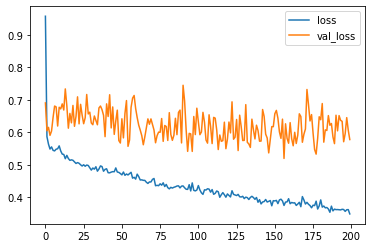

In [12]:
labels = ["loss", "val_loss"]
for label in labels:
    plt.plot(training_result.history[label])
plt.legend(labels)
plt.show()

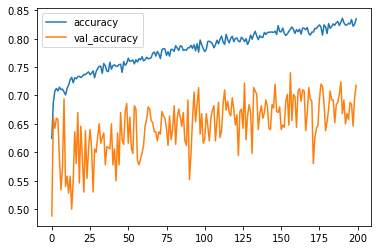

In [13]:
labels = ["accuracy", "val_accuracy"]
for label in labels:
    plt.plot(training_result.history[label])
plt.legend(labels)
plt.show()

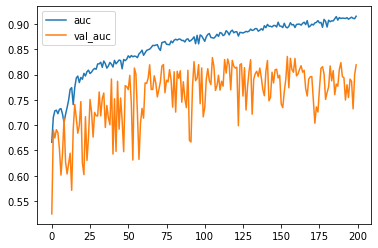

In [14]:
labels = ["auc", "val_auc"]
for label in labels:
    plt.plot(training_result.history[label])
plt.legend(labels)
plt.show()

In [9]:
def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f'Title')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  # print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  # print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  # print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  # print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [10]:
data_tuple = test_data[0]

In [11]:
inputs = data_tuple[0]
print(inputs.shape)
predicted = model.predict(inputs)
ground_truth = [x for x in data_tuple[1]]
predictions = [x[0] for x in predicted]
rounded_ground_truth = [round(x) for x in ground_truth]


(469, 128, 128, 3)


2022-03-10 13:11:49.712188: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-10 13:11:49.742958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [12]:
def ronud_by_threshold(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

In [13]:
def show_f1(threshold):
    rounded_predictions = [ronud_by_threshold(x, threshold) for x in predictions]
    # print(rounded_ground_truth[0], rounded_predictions[0])
    print(f"Accuracy: {accuracy_score(rounded_ground_truth, rounded_predictions)}")
    print(f"F1-score: {f1_score(rounded_ground_truth, rounded_predictions)}")
    plot_cm(rounded_ground_truth, rounded_predictions)

In [14]:
interact(show_f1, threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.show_f1(threshold)>

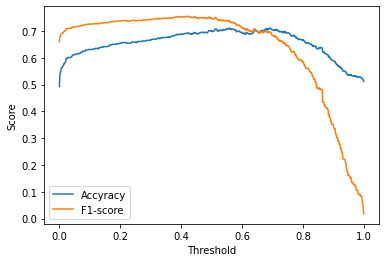

In [15]:
xs = []
accs = []
f1s = []

for i in range(0, 1000):
    x = i / 1000.0
    rounded_predictions = [ronud_by_threshold(temp, x) for temp in predictions]
    acc = accuracy_score(rounded_ground_truth, rounded_predictions)
    f1 = f1_score(rounded_ground_truth, rounded_predictions)

    xs.append(x)
    accs.append(acc)
    f1s.append(f1)

plt.plot(xs, accs)
plt.plot(xs, f1s)
plt.legend(["Accyracy", "F1-score"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

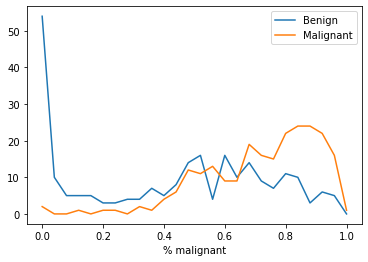

In [16]:
n_bins = 25
benigns = np.zeros(n_bins + 1)
malignants = np.zeros(n_bins + 1)

for i in range(len(rounded_ground_truth)):
    if (rounded_ground_truth[i] == 0):
        benigns[int(predictions[i] * n_bins)] += 1
    else:
        malignants[int(predictions[i] * n_bins)] += 1


# plt.plot(xs, y1s)
# plt.plot(xs, y2s)
plt.plot(np.array(range(n_bins + 1)) * 1.0 / n_bins, benigns)
plt.plot(np.array(range(n_bins + 1)) * 1.0 / n_bins, malignants)

plt.legend(["Benign", "Malignant"])
plt.xlabel("% malignant")
# plt.ylabel("Score")
plt.show()

In [33]:
# plot_cm(rounded_ground_truth, rounded_predictions)